### Import Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import cv2

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils

file path did not work
file path did not work
file path did not work


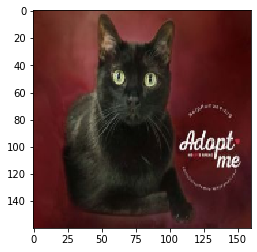

In [2]:
data = []
dirpath = "datasets/cat_imgs"
folders = ['tabby', 'siamese','bombay']
for folder in folders:
    path = os.path.join(dirpath, folder)
    for img_path in os.listdir(path):
        try: 
            image_arr = cv2.imread(os.path.join(path, img_path))
            img_rgb=cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
            new_array = cv2.resize(img_rgb,(160, 160))
            data.append([new_array, folder])
            plt.imshow(new_array)
        except:
            print("file path did not work")

In [3]:
X = []
y = []
for feature, label in data:
    X.append(feature)
    y.append(label)

In [4]:
X = np.array(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [7]:
pd.Series(y).value_counts(normalize=True)

bombay     0.430933
tabby      0.302243
siamese    0.266824
dtype: float64

In [8]:
y_train = pd.Series(y_train, name = 'target')
y_test = pd.Series(y_test, name = 'target')

In [9]:
cats = []
for i, img in enumerate(X_train):
    cat = pd.Series(img.flatten(), name = i)
    cats.append(cat)

In [10]:
cats_test=[]
for a, each in enumerate(X_test):
    cat_test = pd.Series(each.flatten(), name = a)
    cats_test.append(cat_test)

In [11]:
cats = pd.DataFrame(cats)
cats_test = pd.DataFrame(cats_test)

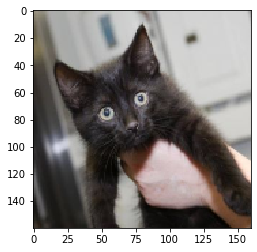

In [12]:
#show original training image
plt.imshow(cats.iloc[8].values.reshape(160, 160, 3))

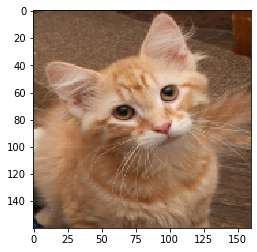

In [13]:
#show original testing image
plt.imshow(cats_test.iloc[8].values.reshape(160, 160, 3))

In [14]:
np.array(cats).shape

(635, 76800)

In [15]:
np.array(cats_test).shape

(212, 76800)

### Image Reconstruction with PCA

In [16]:
#Standardize the data before fit it to PCA
ss = StandardScaler()
train_img = ss.fit_transform(cats)
test_img = ss.transform(cats_test)

In [17]:
# Use PCA to reduce the training and testing datasets to 3 dimensional datasets
pca = PCA(n_components = 3)
cats_train_pca = pca.fit_transform(train_img)
cats_test_pca = pca.transform(test_img)

In [18]:
pca_train = pd.DataFrame(columns=['pc1','pc2'])
pca_test = pd.DataFrame(columns=['pc1','pc2'])

In [19]:
pca_train['pc1'] = cats_train_pca[:,0]
pca_train['pc2'] = cats_train_pca[:,1]
pca_train['pc3'] = cats_train_pca[:,2]

In [20]:
pca_test['pc1'] = cats_test_pca[:,0]
pca_test['pc2'] = cats_test_pca[:,1]

In [21]:
pca_train_df = pd.concat([pca_train, y_train], axis =1)
pca_test_df = pd.concat([pca_test, y_test], axis =1)

Text(0, 0.5, 'principal component 2')

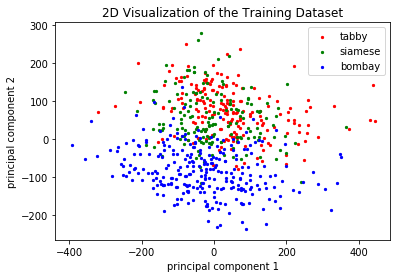

In [22]:
# plot the training dataset as a 2 dimentioanl dataset 
# using the top two principle components which is measured by their eigenvalues
label = ['tabby', 'siamese','bombay']
colors = ['r', 'g', 'b']
for target, color in zip(label,colors):
    indicesToKeep = pca_train_df ['target'] == target
    plt.scatter(pca_train_df.loc[indicesToKeep, 'pc1']
               , pca_train_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 5)
plt.legend(label)
plt.title('2D Visualization of the Training Dataset')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')

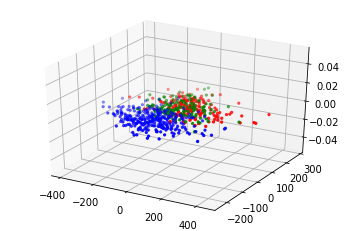

In [23]:
#Adding an additional cluster
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
label = ['tabby', 'siamese','bombay']
colors = ['r', 'g', 'b']
for target, color in zip(label,colors):
    indicesToKeep = pca_train_df ['target'] == target
    ax.scatter3D(pca_train_df.loc[indicesToKeep, 'pc1']
               , pca_train_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 5)

1. Use a for loop to try out how different components affact image recreation
2. Reverse PCA using the number of principle components to reconstruct original image

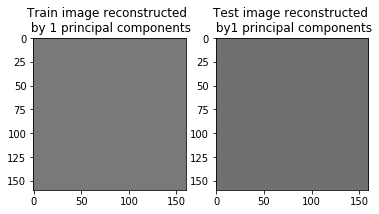

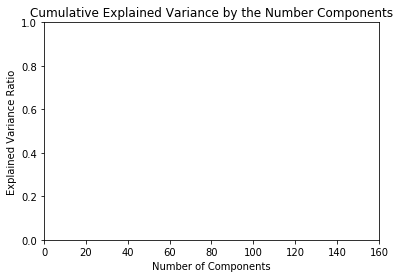

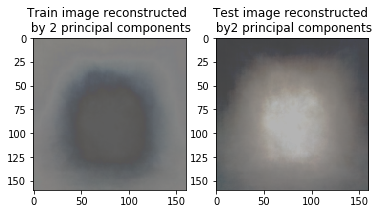

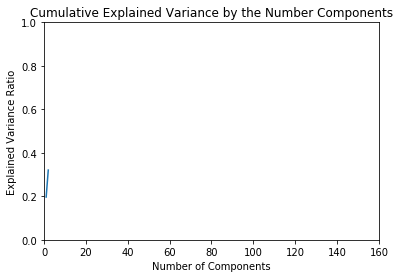

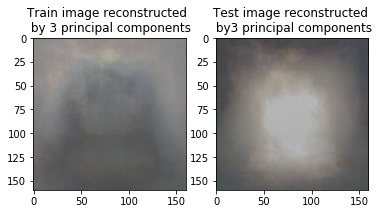

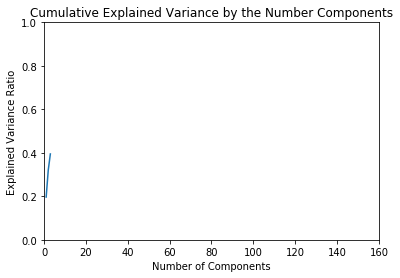

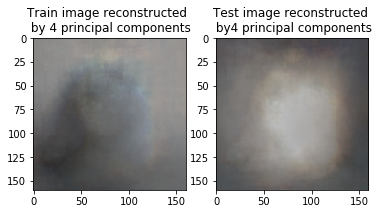

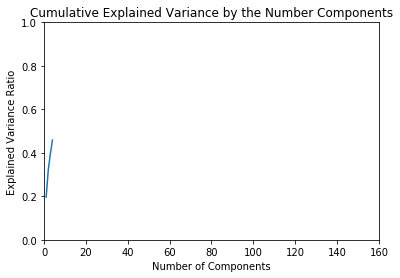

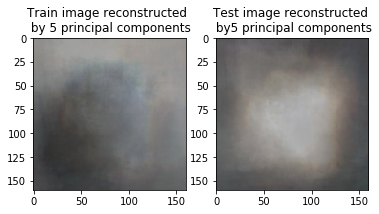

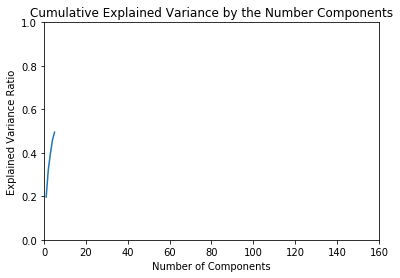

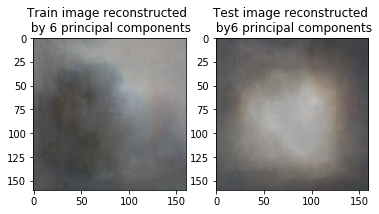

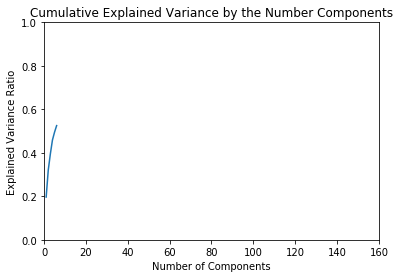

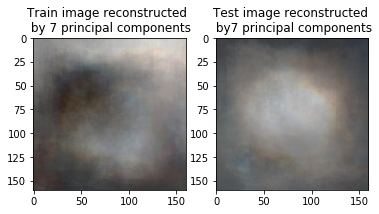

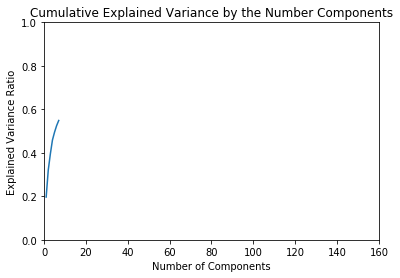

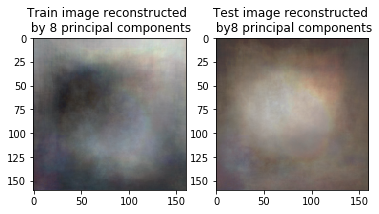

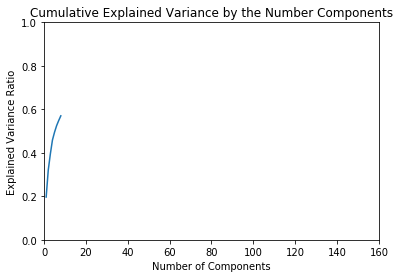

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [24]:
n_components = []
# can set the range to 161 but for easy upload I'm only gonna try out 10
for i in range(1,10):
    #use PCA to reduce the image dimensions by creating new componenets. 
    pca = PCA(n_components = i)
    cats_train_pca = pca.fit_transform(train_img)
    cats_test_pca = pca.transform(test_img)
    
    # inverse it back to image dimensions 
    cats_test_inverse = pca.inverse_transform(cats_test_pca)
    cats_train_inverse = pca.inverse_transform(cats_train_pca)
    
    #scale it back to 0-1 so it can fit into imshow
    scaler = MinMaxScaler()
    cats_train = scaler.fit_transform(cats_train_inverse)
    cats_test = scaler.transform(cats_test_inverse)
    
    #plot the images
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title('Train image reconstructed \n by '+str(i) + ' principal components')
    ax1.imshow(cats_train[8].reshape(160, 160, 3))
    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title('Test image reconstructed \n by'+str(i) + ' principal components')
    ax2.imshow(cats_test[8].reshape(160, 160, 3))
    plt.show() 
    
    ratio = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(ratio)
    n_components.append(i)
    plt.plot(n_components, cum_var_exp)
    plt.title('Cumulative Explained Variance by the Number Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.xlim(0, 160)
    plt.ylim(0, 1)
    plt.show()
    
    plt.tight_layout()

###  Modeling 

In [25]:
pca = PCA(n_components = 0.80)
cats_train_pca = pca.fit_transform(train_img)
cats_test_pca = pca.transform(test_img)

In [26]:
svm = SVC()

In [27]:
params = {'C': [0.01, 1],
         'kernel': ['poly', 'rbf','sigmoid']}

In [28]:
%%time
gs_svm = GridSearchCV(svm, params, cv = 3)
gs_svm.fit(cats_train_pca, y_train)

CPU times: user 278 ms, sys: 2.2 ms, total: 280 ms
Wall time: 279 ms


GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.01, 1], 'kernel': ['poly', 'rbf', 'sigmoid']})

In [28]:
gs_svm.best_params_

{'C': 1, 'kernel': 'rbf'}

In [29]:
svm_pred = gs_svm.predict(cats_test_pca)

In [30]:
gs_svm.score(cats_train_pca, y_train)

0.9310897435897436

In [31]:
gs_svm.score(cats_test_pca, y_test)

0.8509615384615384

In [32]:
def visual_result(i):
    
    cats_test_inverse = pca.inverse_transform(cats_test_pca)
    plt.imshow(np.array(cats_test_inverse[i]).reshape(160, 160, 3),
               interpolation='nearest')
    plt.show()
    print(f'The model guessed this was: {results["predicted"].iloc[i]}.')
    print(f'This actually is: {results["actual"].iloc[i]}.')
    print()

In [33]:
results = pd.DataFrame({'predicted': svm_pred,
                        'actual': y_test})

In [34]:
results.head()

,predicted,actual
0,bombay,bombay
1,bombay,bombay
2,siamese,siamese
3,bombay,bombay
4,tabby,tabby


In [35]:
row_inds = results[results['predicted'] != results['actual']].index

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


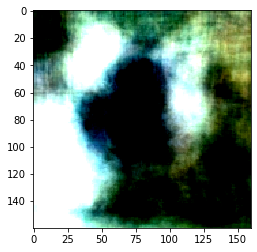

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model guessed this was: bombay.
This actually is: siamese.



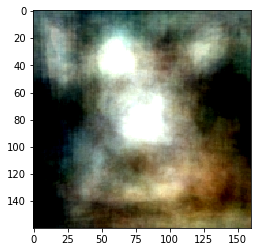

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model guessed this was: tabby.
This actually is: siamese.



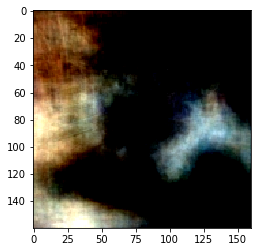

The model guessed this was: siamese.
This actually is: tabby.



In [36]:
for index in row_inds[:3]:
    visual_result(index)

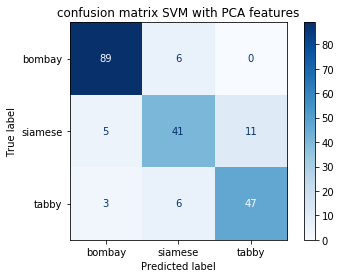

In [37]:
plot_confusion_matrix(gs_svm, cats_test_pca, y_test, cmap = 'Blues', values_format = 'd')
plt.title('confusion matrix SVM with PCA features');

#### Convolutional Neural Network 

In [42]:
y_test = y_test.map({'tabby': 0, 'siamese': 1, 'bombay':2})
y_train = y_train.map({'tabby': 0, 'siamese': 1, 'bombay':2})

In [45]:
y_train = utils.to_categorical(y_train, 3)
y_test = utils.to_categorical(y_test, 3)

In [52]:
cats_train_inverse.shape

(624, 76800)

In [72]:
cat_train = cats_train_inverse.reshape(X_train.shape[0], 160, 160, 3)

In [73]:
cat_test = cats_test_inverse.reshape(X_test.shape[0], 160, 160, 3)

In [74]:
cnn_model = Sequential()

In [75]:
#first convolutional layer
cnn_model.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu',      
                     input_shape=(160, 160, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#second convolutional layer
cnn_model.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#second convolutional layer
cnn_model.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#third convolutional layer
cnn_model.add(Conv2D(filters=512,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#third convolutional layer
cnn_model.add(Conv2D(filters=512,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#flatten the metrics to fit into the Dense layers 
cnn_model.add(Flatten())

In [76]:
cnn_model.add(Dense(2048, activation = 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1024, activation = 'relu'))
cnn_model.add(Dense(1024, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(512, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(512, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(256, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(128, activation = 'relu'))
cnn_model.add(Dropout(0.3))



# The final layer
cnn_model.add(Dense(3, activation = 'softmax'))

In [77]:
# Compile model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [78]:
# Fit model on training data
history = cnn_model.fit(cat_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=30)

Epoch 1/30
5/5 [==============================] - 12s 2s/step - loss: 1.1274 - accuracy: 0.3974 - val_loss: 1.0975 - val_accuracy: 0.4038
Epoch 2/30
5/5 [==============================] - 11s 2s/step - loss: 1.0866 - accuracy: 0.4183 - val_loss: 1.0876 - val_accuracy: 0.4567
Epoch 3/30
5/5 [==============================] - 11s 2s/step - loss: 0.9591 - accuracy: 0.4295 - val_loss: 1.0979 - val_accuracy: 0.2692
Epoch 4/30
5/5 [==============================] - 12s 2s/step - loss: 0.8210 - accuracy: 0.6170 - val_loss: 1.1028 - val_accuracy: 0.2692
Epoch 5/30
5/5 [==============================] - 12s 2s/step - loss: 0.7709 - accuracy: 0.6875 - val_loss: 1.1114 - val_accuracy: 0.2692
Epoch 6/30
5/5 [==============================] - 13s 3s/step - loss: 0.7502 - accuracy: 0.6923 - val_loss: 1.1285 - val_accuracy: 0.2692
Epoch 7/30
5/5 [==============================] - 14s 3s/step - loss: 0.6926 - accuracy: 0.7051 - val_loss: 1.3120 - val_accuracy: 0.2692
Epoch 8/30
5/5 [==================

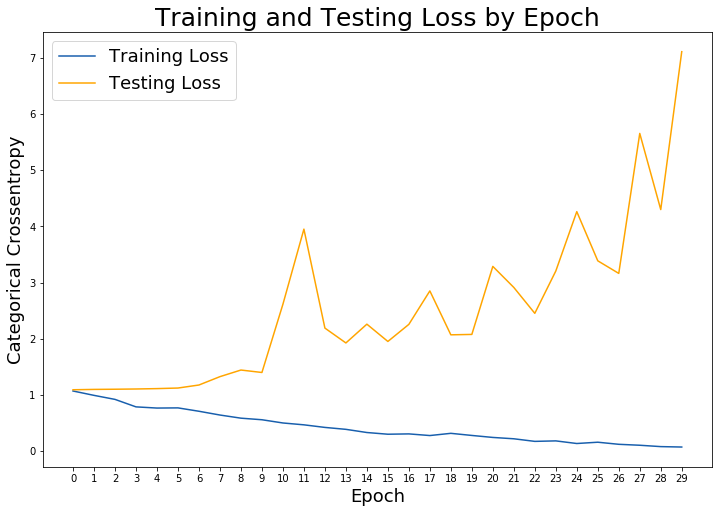

In [61]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

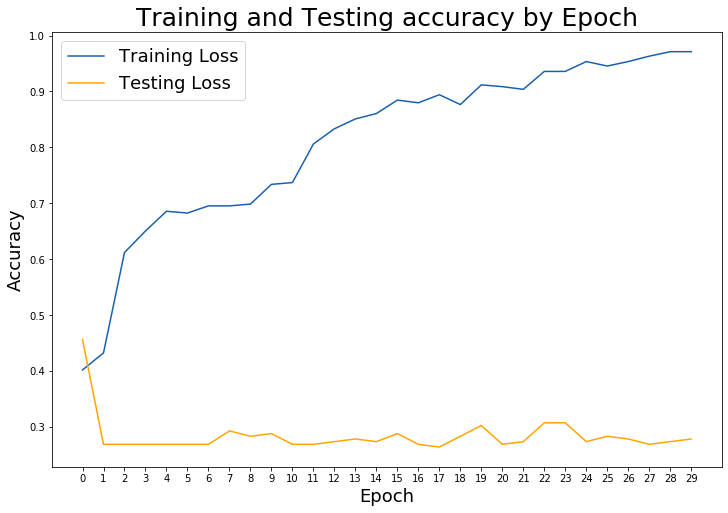

In [62]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);